In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db=mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "Mallubhabi89@",
                            database = "ecommerce")
cur=db.cursor()



# 1. List all unique cities where customers are located.

In [12]:
query = """ select distinct customer_city  from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns = ["Customer Location(city)"])
df.head()

,Customer Location
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [18]:
query="""select count( order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data=cur.fetchall()
"total orders placed in 2017 are",data[0][0]


('total orders placed in 2017 are', 90202)

# 3. Find the total sales per category.

In [20]:
query=""" select upper(products.product_category) category,round(sum(payments.payment_value),2) sales from products join order_items on 
         products.product_id=order_items.product_id join payments on payments.order_id=order_items.order_id
         group by category"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["sales","category"])
df

,sales,category
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


# 4.Calculate the percentage of orders that were paid in installments.


In [33]:
query="""select ((sum(case when payment_installments>1 then 1 else 0 end ))/count(*))*100 from payments"""
cur.execute(query)
data=cur.fetchall()
"The percentage of orders that were paid in installments is",data[0][0]


('The percentage of orders that were paid in installments is',
 Decimal('49.4176'))

# 5.Count the number of customers from each state. 


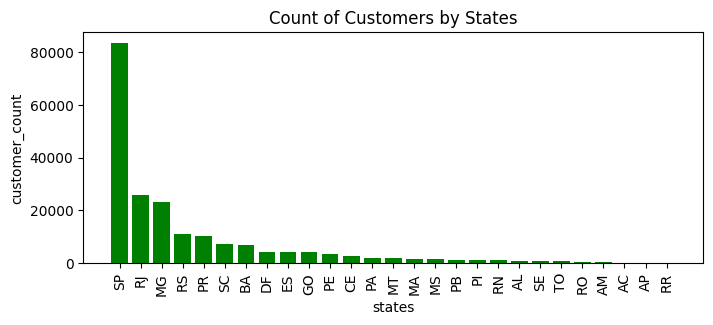

In [48]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""
cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"],color="green")
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# 6.Calculate the number of orders per month in 2018.


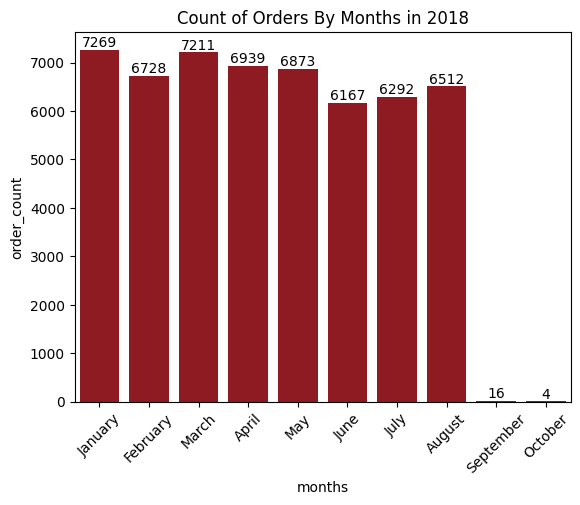

In [84]:
query="""select monthname(order_purchase_timestamp) month,count(distinct order_id) order_count from orders where year(order_purchase_timestamp)=2018 group by month"""
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]
ax=sns.barplot(x=df["months"],y=df["order_count"],data=df,order=o,color="#a10810")
ax.bar_label(ax.containers[0])
plt.xticks(rotation=45)
plt.title("Count of Orders By Months in 2018")
plt.show()












# 7. Find the average number of products per order, grouped by customer city.


In [58]:
query= """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)



,customer city,average products/order
0,padre carvalho,28.00
1,celso ramos,26.00
2,datas,24.00
3,candido godoi,24.00
4,matias olimpio,20.00
5,cidelandia,16.00
6,curralinho,16.00
7,picarra,16.00
8,morro de sao paulo,16.00
9,teixeira soares,16.00


 # 8.Calculate the percentage of total revenue contributed by each product category.


In [63]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86


 # 9.Identify the correlation between product price and the number of times a product has been purchased.

In [85]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])


the correlation is -0.10631514167157562


# 10.Calculate the total revenue generated by each seller, and rank them by revenue.


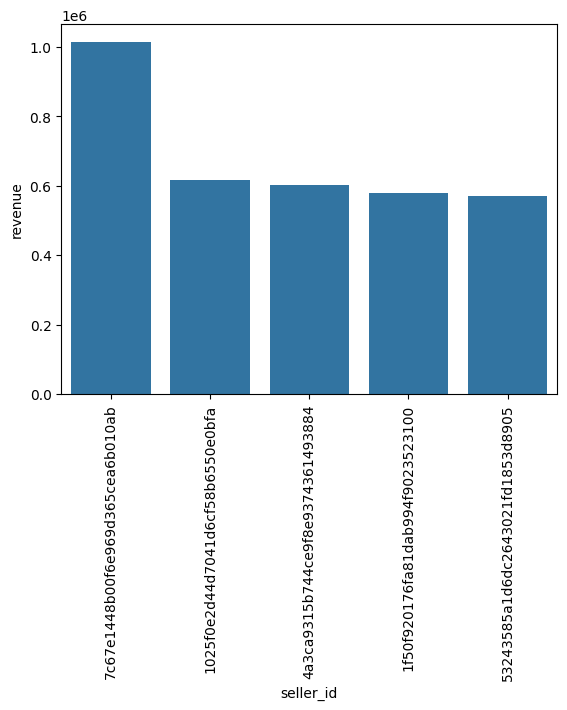

In [89]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()


# 11. Calculate the moving average of order values for each customer over their order history.


In [90]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
...,...,...,...,...
207767,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
207768,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207769,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
207770,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# 12.Calculate the cumulative sales per month for each year.

In [92]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 

(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,504.48,504.48
1,2016,10,118180.96,118685.44
2,2016,12,39.24,118724.68
3,2017,1,276976.08,395700.76
4,2017,2,583816.02,979516.78
5,2017,3,899727.20,1879243.98
6,2017,4,835576.06,2714820.04
7,2017,5,1185837.64,3900657.68
8,2017,6,1022552.76,4923210.44
9,2017,7,1184765.84,6107976.28


# 5. Identify the top 3 customers who spent the most money in each year

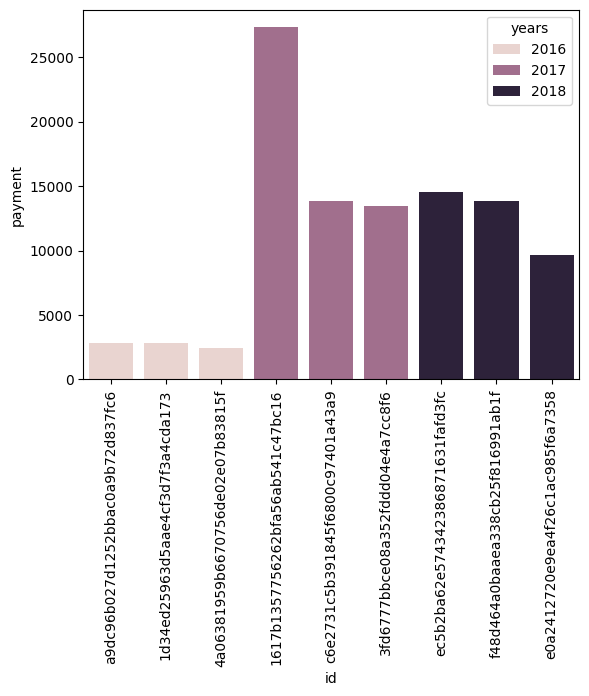

In [93]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()